## Data Drift

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp


## Coviariate Drift

In [27]:
# Settings
np.random.seed(42)
pre_pandemic_months = 24  # 2 years
pandemic_months = 12      # 1 year
post_pandemic_months = 12 # 1 year

In [28]:
# Generate data
# Pre-pandemic spending behavior
pre_pandemic_spending = np.random.normal(1000, 150, pre_pandemic_months)

# Pandemic spending behavior - assume a decrease in spending
pandemic_spending = np.random.normal(700, 200, pandemic_months)

# Post-pandemic spending behavior - could be a new normal
post_pandemic_spending = np.random.normal(950, 180, post_pandemic_months)

In [29]:
# Combine all data
total_spending = np.concatenate([pre_pandemic_spending, pandemic_spending, post_pandemic_spending])
time_period = np.arange(len(total_spending))

# Create DataFrame
df = pd.DataFrame({
    'Month': time_period,
    'Consumer Spending': total_spending
})
# Add a column to indicate the period
df['Period'] = 'Pre-Pandemic'
df.loc[df['Month'] >= pre_pandemic_months, 'Period'] = 'Pandemic'
df.loc[df['Month'] >= pre_pandemic_months + pandemic_months, 'Period'] = 'Post-Pandemic'

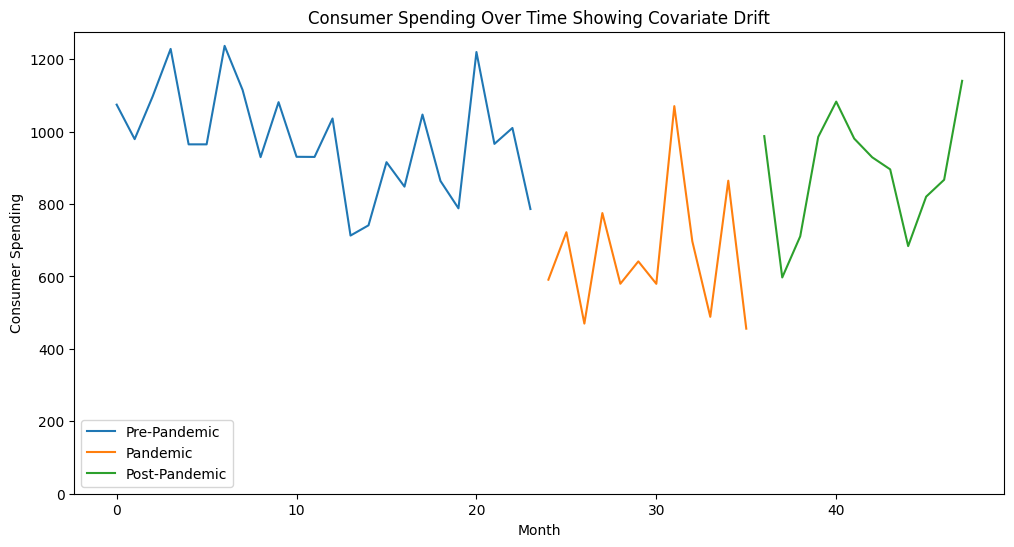

In [30]:
# Plotting
plt.figure(figsize=(12, 6))
for period in ['Pre-Pandemic', 'Pandemic', 'Post-Pandemic']:
    subset = df[df['Period'] == period]
    plt.plot(subset['Month'], subset['Consumer Spending'], label=period)
plt.xlabel('Month')
plt.ylabel('Consumer Spending')
plt.title('Consumer Spending Over Time Showing Covariate Drift')
plt.ylim(bottom=0)  # Set the bottom y-axis limit to 0
plt.legend()
plt.show()

## Prior Probability Drift

In [31]:
# Settings
months = 24  # 2 years

# Simulating investment behavior with a beta distribution
# The parameters a (alpha) and b (beta) control the shape of the distribution
a_investors_pre_pandemic = 7  # alpha > beta, skewed towards 1 (investing)
b_investors_pre_pandemic = 3

a_investors_during_pandemic = 3  # alpha < beta, skewed towards 0 (saving)
b_investors_during_pandemic = 7

# Generate continuous probabilities
investors_pre_pandemic = np.random.beta(a_investors_pre_pandemic, b_investors_pre_pandemic, months // 2)
savers_pre_pandemic = 1 - investors_pre_pandemic

investors_during_pandemic = np.random.beta(a_investors_during_pandemic, b_investors_during_pandemic, months // 2)
savers_during_pandemic = 1 - investors_during_pandemic

# Combine the data
investors = np.concatenate([investors_pre_pandemic, investors_during_pandemic])
savers = np.concatenate([savers_pre_pandemic, savers_during_pandemic])

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Month': np.arange(months) + 1,
    'Investors': investors,
    'Savers': savers
})




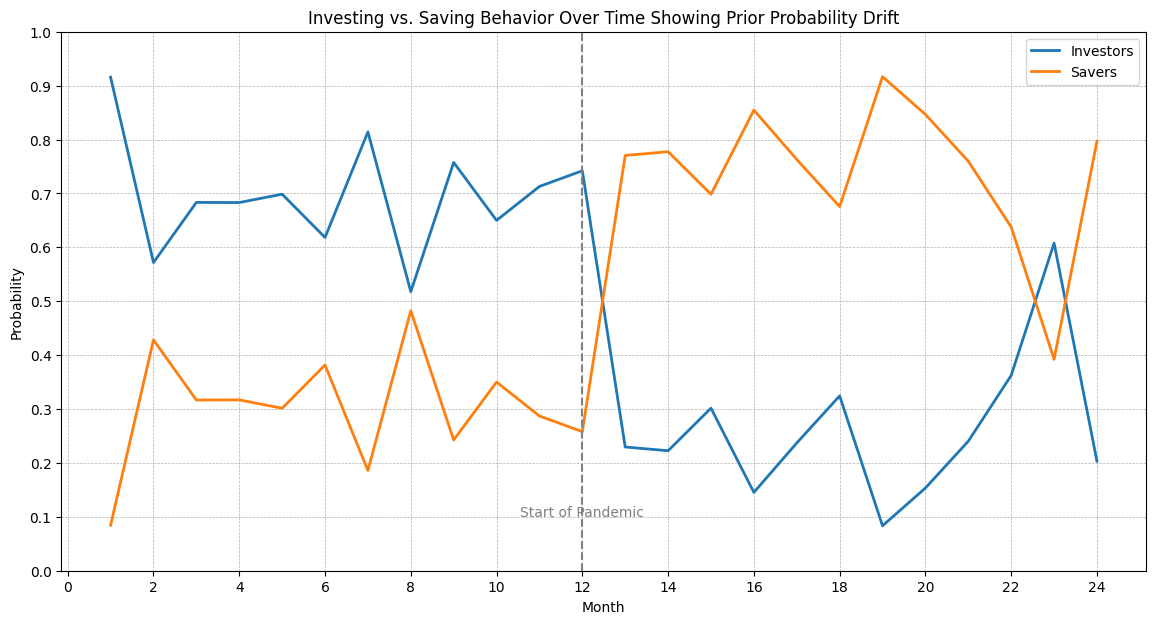

In [32]:
# Plotting
plt.figure(figsize=(14, 7))

plt.plot(df['Month'], df['Investors'], label='Investors', linewidth=2)
plt.plot(df['Month'], df['Savers'], label='Savers', linewidth=2)

# Adding annotations for pandemic period
plt.axvline(x=12, color='grey', linestyle='--')
plt.text(12, 0.1, 'Start of Pandemic', horizontalalignment='center', color='grey')

# Improving the axes
plt.xlabel('Month')
plt.ylabel('Probability')
plt.title('Investing vs. Saving Behavior Over Time Showing Prior Probability Drift')
plt.xticks(range(0, 25, 2))  # Set x ticks to be every two months for clarity
plt.yticks(np.linspace(0, 1, 11))  # Set y ticks to be in increments of 0.1

# Adding gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Ensure the legend is clear and placed appropriately
plt.legend(loc='best')

plt.show()


## Population Stability Index

In [33]:
def calculate_psi(expected, observed, bins=10):
    # Bin the data to get the distribution in each bin
    expected_counts, bin_edges = np.histogram(expected, bins=bins, range=(0, 1))
    observed_counts, _ = np.histogram(observed, bins=bin_edges, range=(0, 1))

    # Calculate the proportions of observations in each bin
    expected_proportions = expected_counts / sum(expected_counts)
    observed_proportions = observed_counts / sum(observed_counts)

    # Replace 0s with a small number to avoid division by zero in PSI calculation
    expected_proportions = np.where(expected_proportions == 0, 0.0001, expected_proportions)
    observed_proportions = np.where(observed_proportions == 0, 0.0001, observed_proportions)

    # Calculate the PSI
    psi_values = (expected_proportions - observed_proportions) * np.log(expected_proportions / observed_proportions)
    psi = sum(psi_values)

    return psi


psi = calculate_psi(investors_pre_pandemic, investors_during_pandemic)
print(f"Population Stability Index: {psi}")
if psi < 0.1:
    print("There is no significant shift.")
elif 0.1 <= psi <= 0.25:
    print("There is a moderate shift.")
else:
  print("There is a significant shift.")


Population Stability Index: 12.069684579465711
There is a significant shift.


## Statistical Testing

In [34]:
# Split the data into two samples
pre_pandemic = df[df['Month'] <= 12]['Investors']
during_pandemic = df[df['Month'] > 12]['Investors']

# Perform Kolmogorov-Smirnov Test
ks_statistic, p_value = ks_2samp(pre_pandemic, during_pandemic)

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05  # Set a threshold for significance
if p_value < alpha:
    print("There is a significant difference between the two distributions. Data drift may have occurred.")
else:
    print("There is no significant difference between the two distributions. Data drift may not have occurred.")


KS Statistic: 0.9166666666666666
P-value: 1.77504552252163e-05
There is a significant difference between the two distributions. Data drift may have occurred.


In [35]:
# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(pre_pandemic, during_pandemic)

stat, p_value
print(f"stat,: {ks_statistic}")
print(f"P-value: {p_value}")
# Interpret the p-value
alpha = 0.05  # Set a threshold for significance
if p_value < alpha:
    print("There is a significant difference between the two distributions. Data drift may have occurred.")
else:
    print("There is no significant difference between the two distributions. Data drift may not have occurred.")

stat,: 0.9166666666666666
P-value: 6.0057602968049e-05
There is a significant difference between the two distributions. Data drift may have occurred.
